In [1]:
import numpy as np
import pandas as pd
import warnings
import random
import h5py
import torch
import matplotlib.pyplot as plt

from matplotlib import pyplot
from IPython.display import display
from torch.utils.data import DataLoader, Dataset
from torch.utils import data
from PIL import Image, ImageDraw


warnings.filterwarnings('ignore')

%matplotlib inline

SEED = 21
random.seed(SEED)
np.random.seed(SEED)

In [2]:
from torchvision import transforms

device = ("cuda" if torch.cuda.is_available() else "cpu")
learning_rate = 0.01
image_size = 96

train_transforms = transforms.Compose([
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(image_size), 
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

print(device)

cuda


In [3]:
class PCamDataset(Dataset):
    def __init__(self, path, transforms):
        self.path = path
        self.X = h5py.File(self.path +'_x.h5', 'r')['x']
        self.y = h5py.File(self.path +'_y.h5', 'r')['y']
        self.transforms = transforms

    def __getitem__(self, index):
        return (self.transforms(Image.fromarray(self.X[index,:,:,:])), self.y[index])

    def __len__(self):
        assert len(self.X) == len(self.y)
        return len(self.X)

In [4]:
data_dir = "../input/patchcamelyon/"

train = PCamDataset(data_dir + "camelyonpatch_level_2_split_train", train_transforms)
valid = PCamDataset(data_dir + "camelyonpatch_level_2_split_valid", test_transforms)
test = PCamDataset(data_dir + "camelyonpatch_level_2_split_test", test_transforms)

print(len(train), len(valid), len(test))

262144 32768 32768


In [5]:
train_loader = DataLoader(train, batch_size=8, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid, batch_size=8, shuffle=False, num_workers=0)
test_loader = DataLoader(test, batch_size=8, shuffle=False, num_workers=0)

In [6]:
import torchvision.models as models
import torch.nn as nn

resnet34 = models.resnet34(pretrained=False, progress=True)

resnet34.fc = nn.Linear(512, 1)

In [7]:
import torch.optim as optim

optimizer = optim.Adam(resnet34.parameters(), lr=learning_rate)
criterion = nn.BCEWithLogitsLoss()

In [8]:
%%time

epochs = 20
train_loss_history = np.empty(0)
train_accuracy_history = np.empty(0)
valid_loss_history = np.empty(0)
valid_accuracy_history = np.empty(0)

resnet34 = resnet34.to(device)

resnet34.train()
for epoch in range(epochs):
    preds_in_current_epoch = torch.empty(0, device=device)
    labels_in_current_epoch = torch.empty(0, device=device)
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        target = torch.reshape(target, (8, 1)).float()
        optimizer.zero_grad()
        out = resnet34(data)
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()
        preds_in_current_epoch = torch.cat((preds_in_current_epoch, torch.sigmoid(out)))
        labels_in_current_epoch = torch.cat((labels_in_current_epoch, target))
    
    labels_in_current_epoch = torch.squeeze(labels_in_current_epoch)
    total = len(labels_in_current_epoch)
    preds_in_current_epoch = torch.squeeze(preds_in_current_epoch)
    correct = ((preds_in_current_epoch > 0.5).float() == labels_in_current_epoch).sum().item()
    loss = criterion(preds_in_current_epoch, labels_in_current_epoch)
    accuracy = round(correct / total, 4)
    
    train_accuracy_history = np.append(train_accuracy_history, accuracy)
    train_loss_history = np.append(train_loss_history, loss.cpu().detach().numpy())

    print(f"Train Epoch: {epoch + 1}, Loss: {loss}, Accuracy: {accuracy}")
    
    valid_labels = (torch.squeeze(torch.as_tensor(valid.y))).to(device)

    with torch.no_grad():
        predictions = torch.Tensor().float().to(device)

        for batch_idx, (data, target) in enumerate(valid_loader):
            data, target = data.to(device), target.to(device)
            target = torch.reshape(target, (8, 1)).float()
            out = resnet34(data)
            predictions = torch.cat((predictions, torch.sigmoid(out)))

        total = valid_labels.shape[0]
        predictions = torch.squeeze(predictions)
        correct = ((predictions > 0.5).float() == valid_labels).sum().item()
        loss = criterion(predictions, valid_labels.float())
        accuracy = round(correct / total, 4)
                                    
        valid_accuracy_history = np.append(valid_accuracy_history, accuracy)
        valid_loss_history = np.append(valid_loss_history, loss.cpu().detach().numpy())

        print(f"Valid Loss: {loss}, Valid Accuracy: {accuracy}")

resnet34.eval()
torch.save(resnet34.state_dict(), "checkpoint.pth")

Train Epoch: 1, Loss: 0.6102055311203003, Accuracy: 0.8293
Valid Loss: 0.605073869228363, Valid Accuracy: 0.8016
Train Epoch: 2, Loss: 0.5730081796646118, Accuracy: 0.8933
Valid Loss: 0.6010828614234924, Valid Accuracy: 0.822
Train Epoch: 3, Loss: 0.5604791641235352, Accuracy: 0.9128
Valid Loss: 0.5939165353775024, Valid Accuracy: 0.8374
Train Epoch: 4, Loss: 0.5536240339279175, Accuracy: 0.9242
Valid Loss: 0.586732029914856, Valid Accuracy: 0.8398
Train Epoch: 5, Loss: 0.5493146181106567, Accuracy: 0.9308
Valid Loss: 0.6050955653190613, Valid Accuracy: 0.8112
Train Epoch: 6, Loss: 0.5463975071907043, Accuracy: 0.9354
Valid Loss: 0.5759325623512268, Valid Accuracy: 0.85
Train Epoch: 7, Loss: 0.5438286662101746, Accuracy: 0.9397
Valid Loss: 0.5775784254074097, Valid Accuracy: 0.8494
Train Epoch: 8, Loss: 0.541728138923645, Accuracy: 0.9428
Valid Loss: 0.5668585300445557, Valid Accuracy: 0.8672
Train Epoch: 9, Loss: 0.5404383540153503, Accuracy: 0.9445
Valid Loss: 0.5716025829315186, Val

In [9]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

classes = ['+', '-']
test_labels = (torch.squeeze(torch.Tensor(test.y))).to(device)

with torch.no_grad():
    predictions = torch.empty(0, device=device)
    
    for batch_idx, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)
        target = torch.reshape(target, (8, 1)).float()
        out = resnet34(data)
        loss = criterion(out, target)
        predictions = torch.cat((predictions, torch.sigmoid(out)))
                                
    total = test_labels.shape[0]
    predictions = torch.squeeze(predictions)
    correct = ((predictions > 0.5).float() == test_labels).sum().item()
    loss = criterion(predictions, test_labels)
    accuracy = round(correct / total, 5)
                                
    print(f"Test Loss: {loss}\nTest Accuracy: {accuracy}")
    
    predictions = predictions.cpu().detach().numpy()
    for i in range(len(predictions)):
        predictions[i] = 1.0 if predictions[i] > 0.5 else 0.0
    
    print(classification_report(test_labels.cpu().detach().numpy(), 
                                predictions, 
                                target_names=classes))
    print(roc_auc_score(test_labels.cpu().detach().numpy(), predictions))

Test Loss: 0.5743542909622192
Test Accuracy: 0.83328
              precision    recall  f1-score   support

           +       0.76      0.96      0.85     16391
           -       0.95      0.70      0.81     16377

    accuracy                           0.83     32768
   macro avg       0.86      0.83      0.83     32768
weighted avg       0.86      0.83      0.83     32768

0.8332265441421445


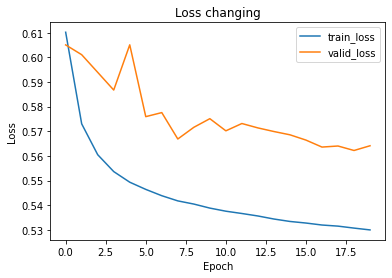

In [10]:
train_loss_idx = list(range(0, len(train_loss_history)))
valid_loss_idx = list(range(0, len(valid_loss_history)))

plt.plot(train_loss_idx, train_loss_history, label="train_loss")
plt.plot(valid_loss_idx, valid_loss_history, label="valid_loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.title("Loss changing")

plt.legend()
plt.show()

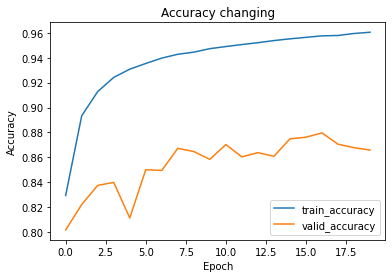

In [11]:
train_accuracy_idx = list(range(0, len(train_accuracy_history)))
valid_accuracy_idx = list(range(0, len(valid_accuracy_history)))

plt.plot(train_accuracy_idx, train_accuracy_history, label="train_accuracy")
plt.plot(valid_accuracy_idx, valid_accuracy_history, label="valid_accuracy")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.title("Accuracy changing")

plt.legend()
plt.show()